# Determining the age of clients

At our disposal are photo portraits and ages (in years) of customers of a supermarket. It is required to train the model to determine the approximate age of the client. This will help analyze purchases and offer products to customers of different age groups, as well as monitor the integrity of cashiers when selling alcohol.

The work is divided into exploratory analysis of the age groups represented in the dataframe, and the training itself, tuning the neural network. Conclusions and assessment of the quality of the resulting model are given at the end of the work.

## Exploratory data analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
print('total missing values:')
print(data.isna().sum())
print('total duplicated items:', data.duplicated().sum())
print('number of images:', len(data))

total missing values:
file_name    0
real_age     0
dtype: int64
total duplicated items: 0
number of images: 7591


Text(0, 0.5, 'Число людей данного возраста')

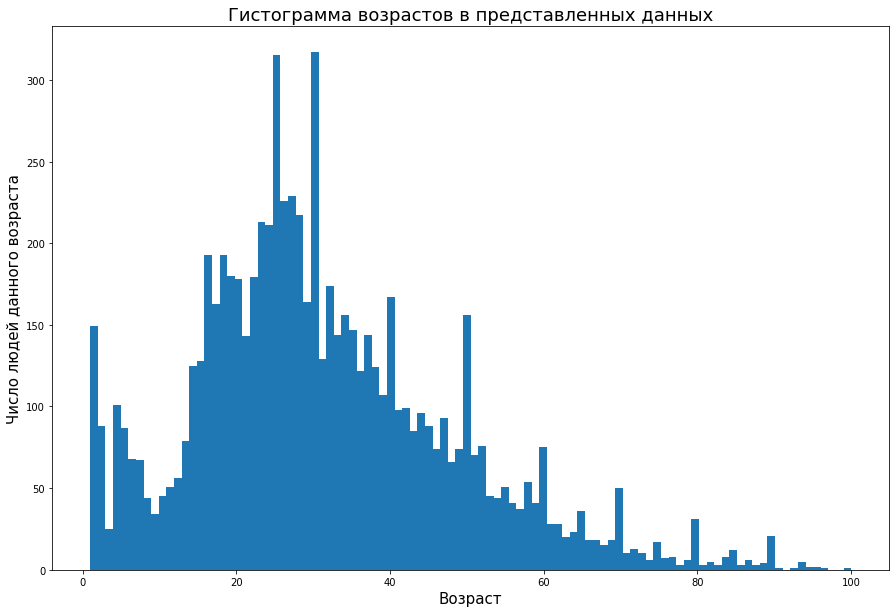

In [7]:
plt.figure(figsize=(15, 10))
plt.hist(data['real_age'], bins=100)
plt.title('Гистограмма возрастов в представленных данных', fontsize=18)
plt.xlabel('Возраст', fontsize=15)
plt.ylabel('Число людей данного возраста', fontsize=15)

In [5]:
data['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

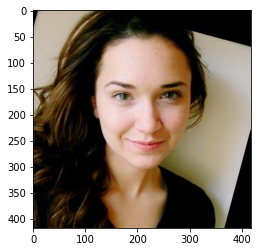

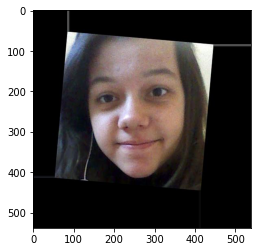

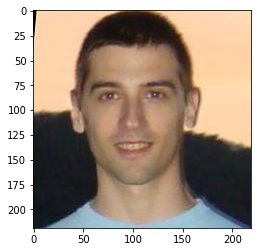

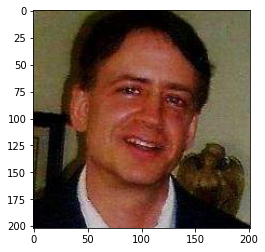

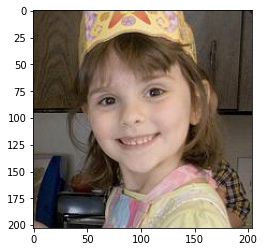

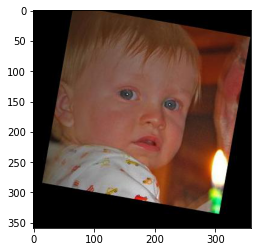

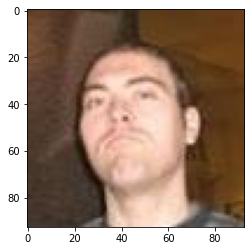

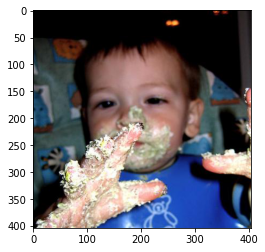

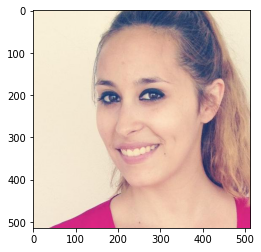

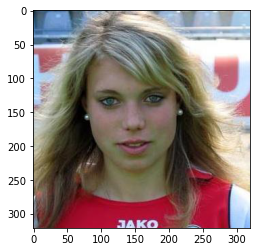

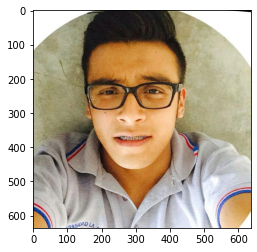

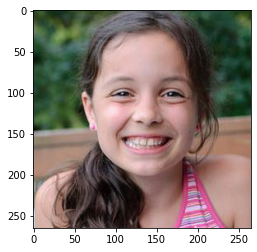

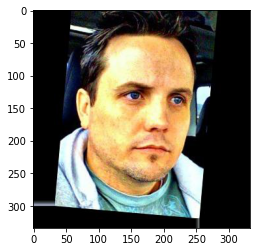

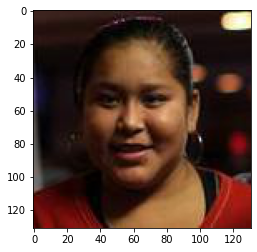

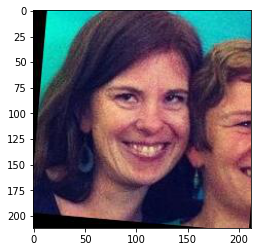

In [6]:
for i in random.sample(range(10, 50), 15):
    image = Image.open(f'/datasets/faces/final_files/0000{i}.jpg')
    plt.imshow(image)
    plt.show()

The dataset contains a total of 7591 photos, which mainly depict portraits of people of different ages. Normal values ​​range from 1 year to 70 years. There are two peaks in the age histogram: around one year old and around 25 years old. Above 75 years - unusually large numbers. This distribution of target features may negatively impact the model, since there is little data on people in adolescence and old age. Some photos are in color, others are black and white.

## Model training

The following line of code was commented out because it was executed with Yandex GPU in a different IDE

_Code:_

```python

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import pandas as pd


def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1./255,
                                       horizontal_flip=True,
                                       zoom_range=0.1)
    data = pd.read_csv('/datasets/faces/labels.csv')
    train_datagen_flow = train_datagen.flow_from_dataframe(data,
                                                           path + 'final_files/',
                                                           x_col='file_name',
                                                           y_col='real_age',
                                                           target_size=(224,224),
                                                           batch_size=16,
                                                           class_mode='raw',
                                                           subset='training',
                                                           seed=12345,)
    return train_datagen_flow


def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1./255)
    data = pd.read_csv('/datasets/faces/labels.csv')
    test_datagen_flow = test_datagen.flow_from_dataframe(data,
                                                           path + 'final_files/',
                                                           x_col='file_name',
                                                           y_col='real_age',
                                                           target_size=(224,224),
                                                           batch_size=16,
                                                           class_mode='raw',
                                                           subset='validation',
                                                           seed=12345,)
    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu', kernel_regularizer=l2(0.01)))
    
    optimizer = Adam(lr=0.0005)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=15, 
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              shuffle=True)
    return model



```

_Model result:_

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/15
356/356 - 76s - loss: 208.2911 - mae: 11.0439 - val_loss: 431.4188 - val_mae: 15.7157
Epoch 2/15
356/356 - 61s - loss: 144.1635 - mae: 9.2244 - val_loss: 224.9764 - val_mae: 11.4471
Epoch 3/15
356/356 - 63s - loss: 123.0821 - mae: 8.5106 - val_loss: 132.5907 - val_mae: 8.8590
Epoch 4/15
356/356 - 70s - loss: 112.0133 - mae: 8.0994 - val_loss: 137.6943 - val_mae: 9.3821
Epoch 5/15
356/356 - 69s - loss: 99.1249 - mae: 7.5975 - val_loss: 148.8797 - val_mae: 9.5434
Epoch 6/15
356/356 - 69s - loss: 91.0423 - mae: 7.3194 - val_loss: 131.2932 - val_mae: 8.7654
Epoch 7/15
356/356 - 70s - loss: 77.9677 - mae: 6.7718 - val_loss: 116.5605 - val_mae: 7.9527
Epoch 8/15
356/356 - 69s - loss: 70.5493 - mae: 6.4927 - val_loss: 125.4157 - val_mae: 8.4097
Epoch 9/15
356/356 - 70s - loss: 67.7916 - mae: 6.3122 - val_loss: 135.6721 - val_mae: 8.5780
Epoch 10/15
356/356 - 63s - loss: 61.5070 - mae: 6.0652 - val_loss: 134.0455 - val_mae: 8.6950
Epoch 11/15
356/356 - 62s - loss: 55.9476 - mae: 5.7373 - val_loss: 118.7779 - val_mae: 8.2889
Epoch 12/15
356/356 - 61s - loss: 49.0104 - mae: 5.4119 - val_loss: 93.1865 - val_mae: 7.1735
Epoch 13/15
356/356 - 62s - loss: 44.7958 - mae: 5.1302 - val_loss: 86.1189 - val_mae: 7.0976
Epoch 14/15
356/356 - 62s - loss: 44.6610 - mae: 5.1495 - val_loss: 90.6567 - val_mae: 7.0481
Epoch 15/15
356/356 - 61s - loss: 39.5291 - mae: 4.8368 - val_loss: 87.6358 - val_mae: 6.9948

119/119 - 10s - loss: 87.6358 - mae: 6.9948
Test MAE: 6.9948

```

## Analysis of the trained model

The resulting model performs well on the training, validation and test samples, since the mean absolute error of its predictions from the actual age of the client does not exceed 8. Indeed, on the test sample the MAE is 7. The network consists of the main backbone of ResNet50 and several additional layers


The model is slightly overfitted, but thanks to regularization and augmentation, the overfitting is not severe. It might have made sense to add a Dropout layer right after the main part of the model to reduce overfitting.